### Predicting if a future crime would result in an arrest or not

Import the necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix,classification_report,f1_score,precision_score,make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import seaborn as sns
import joblib

##### Load the training dataset

In [3]:
crimes_df = pd.read_csv('Crimes-2019_to_2021.csv')
crimes_df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11552667,JC100123,1/1/19 0:00,004XX N STATE ST,890,THEFT,FROM BUILDING,RESTAURANT,False,False,...,42.0,8.0,6,1176302.0,1903096.0,2019,1/10/19 15:16,41.889453,-87.627995,"(41.889453169, -87.627994833)"
1,11552674,JC100085,1/1/19 0:00,092XX S NORMAL AVE,910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,...,21.0,73.0,7,1174586.0,1843723.0,2019,1/10/19 15:16,41.726566,-87.636066,"(41.726566477, -87.636065622)"
2,11552709,JC100020,1/1/19 0:00,044XX S WASHTENAW AVE,486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,...,15.0,58.0,08B,1159112.0,1875020.0,2019,1/10/19 15:16,41.812780,-87.691894,"(41.812780011, -87.691893746)"
3,11552758,JC100058,1/1/19 0:00,063XX S MARSHFIELD AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,...,16.0,67.0,14,1166414.0,1862607.0,2019,1/10/19 15:16,41.778565,-87.665464,"(41.77856457, -87.665463557)"
4,11553168,JC100745,1/1/19 0:00,008XX N MICHIGAN AVE,890,THEFT,FROM BUILDING,RESTAURANT,False,False,...,2.0,8.0,6,1177330.0,1906499.0,2019,1/10/19 15:16,41.898768,-87.624116,"(41.898767916, -87.624116333)"


Performing data cleaning steps

In [4]:
crimes_df = crimes_df.drop_duplicates()

In [5]:
crimes_df.columns = crimes_df.columns.str.strip()
crimes_df.columns = crimes_df.columns.str.replace(' ', '_')
crimes_df.columns = crimes_df.columns.str.lower()

In [6]:
crimes_df.drop(['location','case_number'], axis = 1, inplace = True)

In [7]:
crimes_df['location_description'] = crimes_df['location_description'].fillna('Unavailable')

In [8]:
crimes_df[['x_coordinate', 'y_coordinate']] = crimes_df[['x_coordinate', 'y_coordinate']].replace(0.0, np.nan)
crimes_df.dropna(inplace=True)

In [9]:
crimes_df.isna().sum()

id                      0
date                    0
block                   0
iucr                    0
primary_type            0
description             0
location_description    0
arrest                  0
domestic                0
beat                    0
district                0
ward                    0
community_area          0
fbi_code                0
x_coordinate            0
y_coordinate            0
year                    0
updated_on              0
latitude                0
longitude               0
dtype: int64

To predict if an arrest will happen or no, the following columns are not necessary: "Description", "FBI Code", "Date", "Updated On"

In [10]:
crimes_df = crimes_df.drop(['description','fbi_code','date','updated_on'],axis=1)

Converting object to category

In [11]:
crimes_df['iucr'] = crimes_df['iucr'].astype('category')
crimes_df['block'] = crimes_df['block'].astype('category')
crimes_df['primary_type'] = crimes_df['primary_type'].astype('category')
crimes_df['location_description'] = crimes_df['location_description'].astype('category')

In [12]:
crimes_df['iucr'] = crimes_df['iucr'].cat.codes
crimes_df['block'] = crimes_df['block'].cat.codes
crimes_df['primary_type'] = crimes_df['primary_type'].cat.codes
crimes_df['location_description'] = crimes_df['location_description'].cat.codes

In [13]:
crimes_df

,id,block,iucr,primary_type,location_description,arrest,domestic,beat,district,ward,community_area,x_coordinate,y_coordinate,year,latitude,longitude
0,11552667,2395,320,31,139,False,False,1831,18,42.0,8.0,1176302.0,1903096.0,2019,41.889453,-87.627995
1,11552674,29719,322,17,156,False,False,2223,22,21.0,73.0,1174586.0,1843723.0,2019,41.726566,-87.636066
2,11552709,18996,257,2,17,False,True,922,9,15.0,58.0,1159112.0,1875020.0,2019,41.812780,-87.691894
3,11552758,25143,44,6,17,False,False,725,7,16.0,67.0,1166414.0,1862607.0,2019,41.778565,-87.665464
4,11553168,4240,320,31,139,False,False,1833,18,2.0,8.0,1177330.0,1906499.0,2019,41.898768,-87.624116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680412,12582884,31845,25,9,17,False,False,532,5,9.0,53.0,1178352.0,1827293.0,2021,41.681396,-87.622767
680413,12581143,1499,20,9,171,False,False,113,1,42.0,32.0,1176417.0,1899159.0,2021,41.878647,-87.627691
680414,12582638,27664,309,3,17,False,False,621,6,17.0,69.0,1173874.0,1854232.0,2021,41.755420,-87.638363
680415,12582397,13823,313,31,17,False,False,1414,14,1.0,22.0,1156470.0,1913530.0,2021,41.918509,-87.700544


## Model 1: K-Nearest Neighbors

We are predicting if an arrest will happen or no. So, the target column is arrest

In [14]:
crimes_df_knn = crimes_df

Splitting the dataset into training and testing in the ratio 70:30

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(crimes_df_knn.drop(['arrest'],axis = 1),crimes_df_knn[['arrest']], test_size = 0.3)

In [16]:
X_train= np.asarray(X_train)
Y_train= np.asarray(Y_train)

X_test= np.asarray(X_test)
Y_test= np.asarray(Y_test)

In [17]:
print('Number of training samples: ', X_train.shape[0])
print('Number of testing samples: ', X_test.shape[0])

Number of training samples:  468981
Number of testing samples:  200992


Normalisation - To scale input vectors individually to unit norm (vector length)

In [18]:
normalized_X_train = Normalizer().fit_transform(X_train) 
normalized_X_test = Normalizer().fit_transform(X_test) 

#### Taking k value to be 3

In [21]:
knn3 = KNeighborsClassifier(3)
knn3.fit(normalized_X_train, Y_train.ravel())
y_pred_sklearn = knn3.predict(normalized_X_test)
print(accuracy_score(Y_test,y_pred_sklearn))

0.7914494109218277


We see that the accuracy is 79%. But this is for a randome value of k. Now, let us find out if we can get better accuracy with a different value of k

### Finding the most optimal value of k to give us the best accuracy

In [30]:
accuracy_rate = []
for i in range(1,50,2):
    knn = KNeighborsClassifier(i)
    knn.fit(normalized_X_train,Y_train.ravel())
    Y_pred = knn.predict(normalized_X_test)
    accuracy_rate.append(accuracy_score(Y_test,Y_pred))

Text(0, 0.5, 'Accuracy Rate')

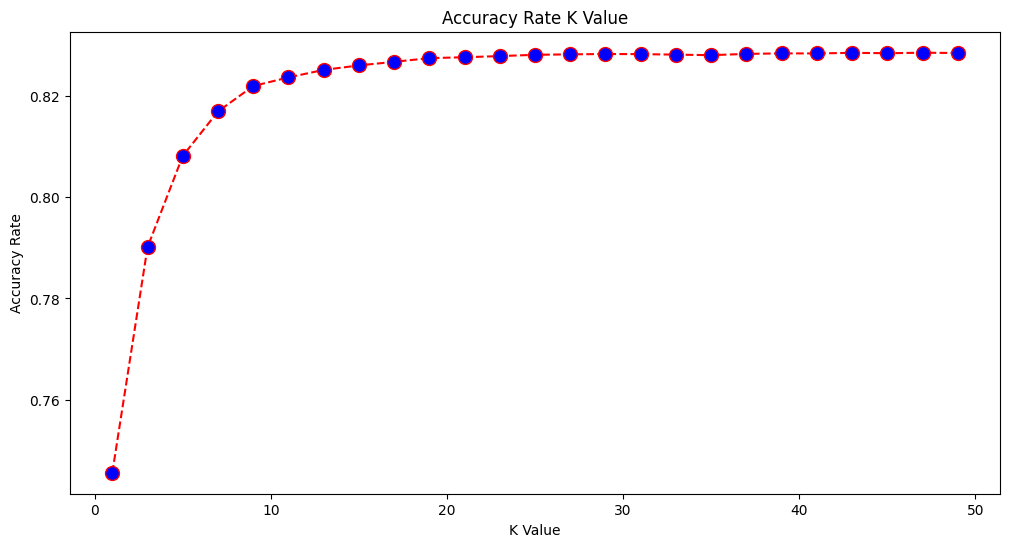

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(range(1,50,2), accuracy_rate, color='red', linestyle='dashed', marker='o',
        markerfacecolor='blue', markersize=10)
plt.title('Accuracy Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Accuracy Rate')

##### Here, we see that choosing k value to be 11 gives us a higher accuracy without overfitting the model. We now found our optimal value for k!

### Retraining the model with k = 11

In [21]:
knn11 = KNeighborsClassifier(11)
knn11.fit(normalized_X_train, Y_train.ravel())
y_pred_sklearn = knn11.predict(normalized_X_test)
print(accuracy_score(Y_test,y_pred_sklearn))

0.8245203789205541


#### Therefore, we see that we get an accuracy of 82.4% to predict whether an arrest will happen or no using K-Nearest Neighbors technique (K=11)

In [33]:
conf_matrix_knn = confusion_matrix(Y_test,y_pred_sklearn)
conf_matrix_knn

array([[162660,   3764],
       [ 31668,   2900]])

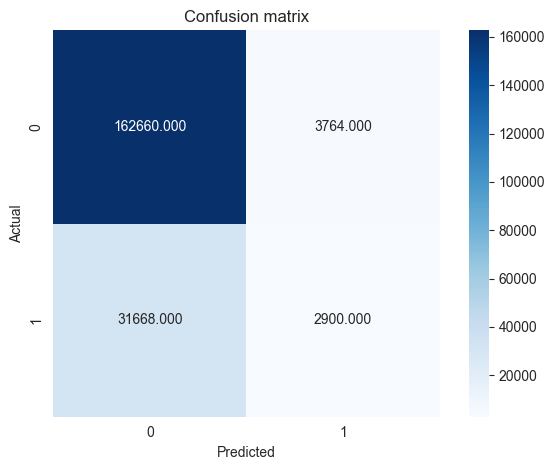

In [34]:
sns.set_style("darkgrid")
sns.heatmap(conf_matrix_knn, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

- To look more into this model, I created a confusion matrix showing the model’s prediction of arrest rate
- You can see the largest value is a was a true positive: a true arrest prediction (162732). There are a significant amount of false negatives (31511) but very few false positives (3856)
- I argue that false positives are worse than false negatives in this business case: if a crime company or the Chicago PD was to predict someone would get arrested, but they did not, it could persuade them to arrest someone that perhaps does not deserve it

In [35]:
print(classification_report(Y_test,y_pred_sklearn))

              precision    recall  f1-score   support

       False       0.84      0.98      0.90    166424
        True       0.44      0.08      0.14     34568

    accuracy                           0.82    200992
   macro avg       0.64      0.53      0.52    200992
weighted avg       0.77      0.82      0.77    200992



## Model 2: Random forest classifier with Hyperparameter tuning using RandomisedSearchCV

In [41]:
crimes_df_clustering = crimes_df

Splitting the dataset into training and testing in the ratio 70:30

In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(crimes_df_clustering.drop(['arrest'],axis = 1),crimes_df_clustering[['arrest']], test_size = 0.3, random_state = 0)

Since our target column is arrest. We are dropping the column arrest while feeding in the X value and only giving in the arrest column while feeding the Y value (target)

Standardising the data

In [45]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

Standardising is done to improve the quality of data by removing the mean and scaling to unit variance

In [49]:
model_params = {
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators':list(range(100, 300, 10)),
            'min_samples_leaf':list(range(1, 50)),
            'max_depth':list(range(2, 20)),
            'max_features':['log2', 'sqrt'],
            'bootstrap':[True, False],
            'criterion' : ["gini","entropy"],
        }
    }
}

These are the different hyperparameters we want our model to check before arriving at an optimal set of parameters to give us the best model

In [330]:
def my_custom_loss_func(y_true, y_pred):
    p_score = accuracy_score(y_true, y_pred)
    return p_score

In [331]:
# K-FOLD SPLIT

kfold_splits = 3
kf = StratifiedKFold(n_splits=kfold_splits)
custom_score = make_scorer(my_custom_loss_func, greater_is_better=True)
model_list = []

There are 2 ways we can do hyperparameter tuning:
- GridSearchCV
- RandomisedSearchCV  

When we take a ML model there are different hyperparameters we need to work on and there can be different possibilities that a hyperparameter can take. 

1. GridSearchCV - When we use GridSearchCV technique, we will try to use all those values so in each time we will try to check that particular hyperparameter value and see which value is giving us the highest accuracy. Since GridSearchCV uses each and every combination to build and evaluate the model performance, this method is highly computational expensive

2. RandomisedSearchCV - In this, instead of calculating the performance of the model for different combinations of hyperparameters, we will randomly select only few parameters and then we will try to find which is the best value

I chose *RandomisedSearchCV* because we have many combinations of parameters. Running GridSearchCV would be very computationally intensive. 

In [332]:
for model_name, mp in model_params.items():
    print("1")
    clf_recall = RandomizedSearchCV(mp['model'], mp['params'], n_jobs=11, cv=kf, scoring=custom_score, verbose=10, return_train_score=False)
    print("2")
    clf_recall.fit(X_train, Y_train.values.ravel())
    print("3")
    Y_predict = clf_recall.predict(X_test_std)
    print("4")
    confusion_matrix_RF = confusion_matrix(Y_test, Y_predict)

1
2
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 3/3; 1/10] START bootstrap=False, criterion=entropy, max_depth=17, max_features=sqrt, min_samples_leaf=40, n_estimators=240
[CV 2/3; 1/10] START bootstrap=False, criterion=entropy, max_depth=17, max_features=sqrt, min_samples_leaf=40, n_estimators=240
[CV 1/3; 1/10] START bootstrap=False, criterion=entropy, max_depth=17, max_features=sqrt, min_samples_leaf=40, n_estimators=240
[CV 1/3; 2/10] START bootstrap=True, criterion=gini, max_depth=12, max_features=sqrt, min_samples_leaf=47, n_estimators=150
[CV 2/3; 3/10] START bootstrap=False, criterion=entropy, max_depth=11, max_features=log2, min_samples_leaf=11, n_estimators=170
[CV 1/3; 3/10] START bootstrap=False, criterion=entropy, max_depth=11, max_features=log2, min_samples_leaf=11, n_estimators=170
[CV 3/3; 2/10] START bootstrap=True, criterion=gini, max_depth=12, max_features=sqrt, min_samples_leaf=47, n_estimators=150
[CV 2/3; 2/10] START bootstrap=True, criterion=

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


4


Using best_params_ we get the best set of hyperparameters that will give us the most optimal result

In [65]:
#------------------------Saving Random Search------------------------------
model_file = 'Random_Search.pkl'
joblib.dump(clf_recall, model_file)

['Random_Search.pkl']

In [333]:
print(clf_recall.best_params_)

{'n_estimators': 150, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 19, 'criterion': 'gini', 'bootstrap': True}


Using best_score_ we get the accuracy of our model using the best chosen combination of hyperparameters

In [334]:
print(clf_recall.best_score_)

0.9076209910422811


In [337]:
model_rf = RandomForestClassifier(n_estimators=150, min_samples_leaf=1, max_features='sqrt', max_depth=19, criterion='gini', bootstrap=True)

In [338]:
model_rf.fit(X_train,Y_train.values.ravel())

RandomForestClassifier(max_depth=19, n_estimators=150)

Predicting using the test data from train-test-split

In [341]:
y_pred_random_forest = model_rf.predict(X_test)

In [342]:
print('Accuracy = ',accuracy_score(Y_test, y_pred_random_forest))

Accuracy =  0.9083097834739691


The accuracy has significantly increased using Random Forest classifier with hyperparameter tuning. We achieved the highest accuracy of 90.83% i.e., our predictions are 90+% correct to give us the right prediction whether an arrest will happen or no

In [343]:
conf_matrix_RF = confusion_matrix(Y_test, y_pred_random_forest)
print(conf_matrix_RF)

[[165067   1617]
 [ 16812  17496]]


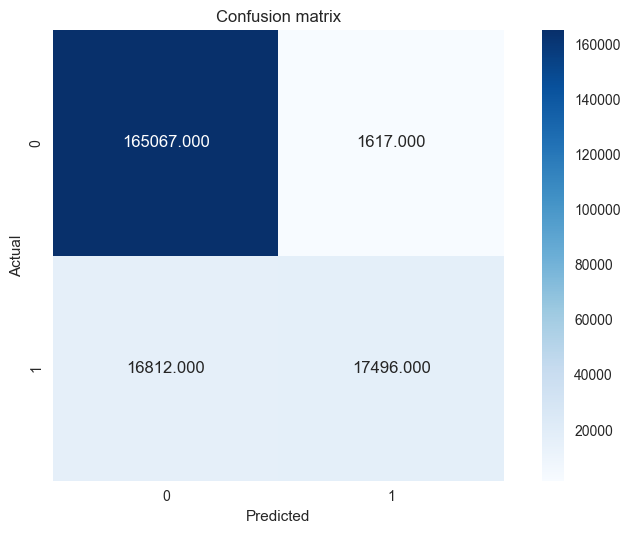

In [344]:
sns.set_style("darkgrid")
sns.heatmap(conf_matrix_RF, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

Confusion matrix showing the model’s prediction of arrest rate. You can see the largest value is a true positive: a true arrest prediction (165067). There are also a good number of true negatives which would rightly predict when the arrest won't happen,


In [345]:
TN = conf_matrix_RF[0][0]
FN = conf_matrix_RF[1][0]
TP = conf_matrix_RF[1][1]
FP = conf_matrix_RF[0][1]
            
FPR = (FP/(FP+TN)) * 100
print("The false positive rate is:  ",FPR,"%")

The false positive rate is:   0.9700991096925919 %


- There are very few false positives (1617) and the False Positive Rate (FPR) is 0.97% which is low. So, in the case when an actual arrest does not happen, our model does not predict that it has happened (which could be very dangerous)
- There are still a lot of False negatives but this isn't as much as an issue because we are not falsely predicting that people are arrested
- This ensures innocent people are not falsely accused even though a few criminals are not proven guilty

View the classification report for test data and predictions

In [346]:
print(classification_report(Y_test, y_pred_random_forest))

              precision    recall  f1-score   support

       False       0.91      0.99      0.95    166684
        True       0.92      0.51      0.66     34308

    accuracy                           0.91    200992
   macro avg       0.91      0.75      0.80    200992
weighted avg       0.91      0.91      0.90    200992



In [347]:
from yellowbrick.classifier import ClassificationReport

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


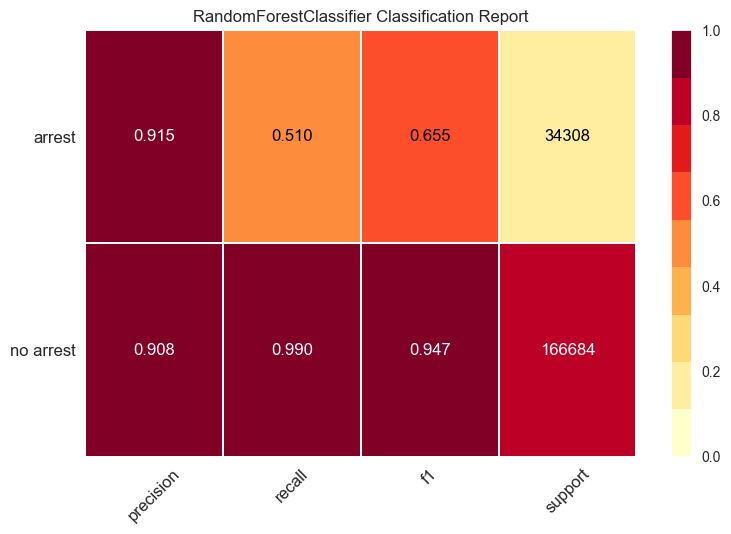

<AxesSubplot: title={'center': 'RandomForestClassifier Classification Report'}>

In [348]:
classes=['no arrest','arrest']

visualizer = ClassificationReport(model_rf, classes=classes, support=True)
visualizer.fit(X_train, Y_train)        # Fit the visualizer and the model
visualizer.score(X_test, Y_test)        # Evaluate the model on the test data
visualizer.show()

#### Prediction on test data

Here, I am using the data of the current year (2022) for validation

In [309]:
crimes_df_validation_rf = pd.read_csv('Crimes-2022.csv')

In [310]:
crimes_df_validation_rf.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,12789250,JF351068,01/01/2022 12:00:00 AM,079XX S ST LAWRENCE AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,...,6.0,44,06,1181612.0,1852489.0,2022,11/12/2022 03:46:21 PM,41.750462,-87.610059,"(41.75046233, -87.610058986)"
1,12783300,JF343908,01/01/2022 12:00:00 AM,007XX N MICHIGAN AVE,0580,STALKING,SIMPLE,STREET,False,False,...,42.0,8,08A,1177293.0,1905597.0,2022,11/12/2022 03:46:21 PM,41.896294,-87.624280,"(41.896293625, -87.624279611)"
2,12814497,JF380963,01/01/2022 12:00:00 AM,047XX W WABANSIA AVE,1563,SEX OFFENSE,CRIMINAL SEXUAL ABUSE,RESIDENCE - GARAGE,False,True,...,37.0,25,17,1144610.0,1910885.0,2022,11/12/2022 03:46:21 PM,41.911483,-87.744185,"(41.911482929, -87.744185282)"
3,12822046,JF389504,01/01/2022 12:00:00 AM,039XX N PINE GROVE AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,APARTMENT,False,False,...,46.0,6,11,1170694.0,1926410.0,2022,11/12/2022 03:46:21 PM,41.953553,-87.647905,"(41.953552585, -87.647905229)"
4,12836994,JF403613,01/01/2022 12:00:00 AM,042XX W WASHINGTON BLVD,1750,OFFENSE INVOLVING CHILDREN,CHILD ABUSE,RESIDENCE,False,True,...,28.0,26,08B,1148076.0,1900155.0,2022,11/12/2022 03:46:21 PM,41.881973,-87.731729,"(41.881972634, -87.731728591)"


Performing all the initial data prep as done for the training dataset

In [312]:
crimes_df_validation_rf.columns = crimes_df_validation_rf.columns.str.strip()
crimes_df_validation_rf.columns = crimes_df_validation_rf.columns.str.replace(' ', '_')
crimes_df_validation_rf.columns = crimes_df_validation_rf.columns.str.lower()

crimes_df_validation_rf.dropna(subset = ['latitude','longitude','ward'], inplace = True)
crimes_df_validation_rf.reset_index(drop = True, inplace = True)

crimes_df_validation_rf.drop(['location','case_number'], axis = 1, inplace = True)

crimes_df_validation_rf = crimes_df_validation_rf.drop(['description','fbi_code','date','updated_on'],axis=1)

crimes_df_validation_rf['location_description'] = crimes_df_validation_rf['location_description'].fillna('Unavailable')

In [316]:
crimes_df_validation_rf['iucr'] = crimes_df_validation_rf['iucr'].astype('category')
crimes_df_validation_rf['block'] = crimes_df_validation_rf['block'].astype('category')
crimes_df_validation_rf['primary_type'] = crimes_df_validation_rf['primary_type'].astype('category')
crimes_df_validation_rf['location_description'] = crimes_df_validation_rf['location_description'].astype('category')

crimes_df_validation_rf['iucr'] = crimes_df_validation_rf['iucr'].cat.codes
crimes_df_validation_rf['block'] = crimes_df_validation_rf['block'].cat.codes
crimes_df_validation_rf['primary_type'] = crimes_df_validation_rf['primary_type'].cat.codes
crimes_df_validation_rf['location_description'] = crimes_df_validation_rf['location_description'].cat.codes

Dividing dependent and independent variables

In [317]:
X_validate = crimes_df_validation_rf.drop(['arrest'],axis=1)

In [318]:
model_load_rf = joblib.load('Random_Search.pkl')

Prediction

In [319]:
Y_predict_Validation = model_load_rf.predict(X_validate)
Y_predict_Validation

array([False, False, False, ..., False, False, False])

Appending a column predicted to store the predicted values

In [325]:
crimes_df_validation_rf['predicted'] = pd.DataFrame(Y_predict_Validation,columns=['predicted'])

In [326]:
crimes_df_validation_rf

,id,block,iucr,primary_type,location_description,arrest,domestic,beat,district,ward,community_area,x_coordinate,y_coordinate,year,latitude,longitude,predicted
0,12789250,23468,75,29,100,False,False,624,6,6.0,44,1181612.0,1852489.0,2022,41.750462,-87.610059,False
1,12783300,3014,68,28,116,False,False,1833,18,42.0,8,1177293.0,1905597.0,2022,41.896294,-87.624280,False
2,12814497,16584,169,27,101,False,True,2533,25,37.0,25,1144610.0,1910885.0,2022,41.911483,-87.744185,False
3,12822046,14352,113,8,17,False,False,1925,19,46.0,6,1170694.0,1926410.0,2022,41.953553,-87.647905,False
4,12836994,15287,185,20,100,False,True,1114,11,28.0,26,1148076.0,1900155.0,2022,41.881973,-87.731729,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211369,12904863,15535,131,5,116,False,False,1013,10,22.0,29,1148171.0,1888007.0,2022,41.848635,-87.731692,False
211370,12904587,17604,46,2,100,False,True,811,8,14.0,56,1134577.0,1869832.0,2022,41.799011,-87.782012,False
211371,12904961,14888,92,16,116,False,False,1912,19,47.0,5,1162927.0,1927726.0,2022,41.957331,-87.676420,False
211372,12904942,22858,75,29,116,False,False,624,6,6.0,69,1181872.0,1855091.0,2022,41.757596,-87.609026,False


Displaying the predicted and actual values for all the values in the test dataset

In [328]:
Y_random_search_results = pd.DataFrame()
Y_random_search_results = pd.DataFrame(Y_predict_Validation,columns=["predicted"])
Y_random_search_results['actual'] = crimes_df_validation_rf[['arrest']]
Y_random_search_results.head()

,predicted,actual
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False


Confusion matrix for the test dataset prediction

In [323]:
conf_matrix_check = confusion_matrix(Y_random_search_results['actual'],Y_random_search_results['predicted'])
conf_matrix_check

array([[187433,    121],
       [ 23596,    224]])

Test accuracy

In [324]:
print('Accuracy = ',accuracy_score(Y_random_search_results['actual'],Y_random_search_results['predicted']))

Accuracy =  0.887796039247968


- The model achieved a training accuracy of 90.83%. This accuracy is based on the test set that we got from train-test-split
- The testing accuracy for this model is 88.77%. This test data is external and the model hasn't seen these values before
- For this, the model predicted with an accuracy of 88.77% on future data whether a crime would result in an arrest or no